In [39]:
# QP solvers installation

%pip install qpsolvers
%pip install qpsolvers[open_source_solvers]

In [77]:
import numpy as np
from qpsolvers import solve_qp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
np.set_printoptions(precision=3)

## Input data

In [6]:
n_companies = 8

carbon_emissions = { # in ktCO2e
    'scope_1': np.array([75, 5000, 720, 50, 2500, 25, 30000, 5]),
    'scope_2': np.array([75, 5000, 1030, 350, 4500, 5, 2000, 64]),
    'scope_3': np.array([200, 500, 520, 850, 8000, 50, 200, 146])
}

revenue = np.array([300, 328, 125, 100, 200, 102, 107, 25]) # in $ bn

sector_1 = np.array([1, 0, 1, 1, 0, 1, 0, 0]) # indicator of sector 1
sector_2 = np.array([0, 1, 0, 0, 1, 0, 1, 1]) # indicator of sector 2

In [32]:
vol_array = 0.01 * np.array([12, 21, 23, 19, 20, 33, 43, 19]) # volatility of returns

correl_mat = 0.01 * np.array([
    [100, 0, 0, 0, 0, 0, 0, 0],
    [80, 100, 0, 0, 0, 0, 0, 0],
    [70, 75, 100, 0, 0, 0, 0, 0],
    [60, 65, 80, 100, 0, 0 ,0, 0],
    [70, 50, 70, 85, 100, 0, 0, 0],
    [50, 60, 70, 80, 60, 100, 0, 0],
    [70, 50, 70, 75, 80, 50, 100, 0],
    [70, 75, 80, 85, 75, 80, 70, 100]
])
correl_mat = (correl_mat + correl_mat.T) - np.eye(n_companies)

weights_ref = 0.01 * np.array([20, 17, 17, 13, 11, 10, 6, 6])

print("Correlation matrix =\n", correl_mat)

Correlation matrix =
 [[1.   0.8  0.7  0.6  0.7  0.5  0.7  0.7 ]
 [0.8  1.   0.75 0.65 0.5  0.6  0.5  0.75]
 [0.7  0.75 1.   0.8  0.7  0.7  0.7  0.8 ]
 [0.6  0.65 0.8  1.   0.85 0.8  0.75 0.85]
 [0.7  0.5  0.7  0.85 1.   0.6  0.8  0.75]
 [0.5  0.6  0.7  0.8  0.6  1.   0.5  0.8 ]
 [0.7  0.5  0.7  0.75 0.8  0.5  1.   0.7 ]
 [0.7  0.75 0.8  0.85 0.75 0.8  0.7  1.  ]]


### Question 1

Calculation of carbon intencities for reference portfolio $b$. 

(a) Carbon intensities $\mathcal{CI}_{1+2}$ for scopes $1 + 2$ decribe the company's carbon emissions per revenue (ktCO2e per $1 mn revenue):
$$
\mathcal{CI}_{i, 1+2} = \dfrac{\mathcal{CE}_{i, 1} + \mathcal{CE}_{i, 2}}{Y}
$$

In [19]:
carbon_intensity_12 = (carbon_emissions['scope_1'] + carbon_emissions['scope_2']) / revenue
print('Carbon intensities (scope 1 + scope 2):\n', carbon_intensity_12)

Carbon intensities (scope 1 + scope 2):
 [5.000e-01 3.049e+01 1.400e+01 4.000e+00 3.500e+01 2.941e-01 2.991e+02
 2.760e+00]


(b) Weighed average carbon intensity of bechmark is given by
$$
\mathcal{CI}_{1+2}(b) = \sum_{i}b_{i} \mathcal{CI}_{i, 1+2}
$$

In [31]:
waci_ref_12 = weights_ref @ carbon_intensity_12
print('Benchmark WACI =', waci_ref_12)

Benchmark WACI = 30.171863827619035


(c) The same questions for scopes $1 + 2 + 3$.

$$
\mathcal{CI}_{i, 1+2+3} = \dfrac{\mathcal{CE}_{i, 1} + \mathcal{CE}_{i, 2} + \mathcal{CE}_{i, 3}}{Y}
$$

$$
\mathcal{CI}_{1+2+3}(b) = \sum_{i}b_{i} \mathcal{CI}_{i, 1+2+3}
$$

In [16]:
carbon_intensity_123 = (carbon_emissions['scope_1'] + carbon_emissions['scope_2'] + carbon_emissions['scope_3']) / revenue
print('Carbon intensities (scope 1 + scope 2 + scope 3):\n', carbon_intensity_123)

Carbon intensities (scope 1 + scope 2 + scope 3):
 [  1.167  32.012  18.16   12.5    75.      0.784 300.935   8.6  ]


In [30]:
waci_ref_123 = weights_ref @ carbon_intensity_123
print('Benchmark WACI =', waci_ref_123)

Benchmark WACI = 37.288112642969196


### Question 2

The goal is to reduce the WACI of the benchmark portfolio by rate $\mathcal{R}$.

(a) The elements of covariance matrix $\Sigma$ are equal
$$
\Sigma_{ij} = \rho_{ij} \sigma_i \sigma_j
$$

In [28]:
cov_mat = (vol_array[:, None] @ vol_array[None, :]) * correl_mat
print('Covariance matrix = \n', cov_mat)

Covariance matrix = 
 [[0.014 0.02  0.019 0.014 0.017 0.02  0.036 0.016]
 [0.02  0.044 0.036 0.026 0.021 0.042 0.045 0.03 ]
 [0.019 0.036 0.053 0.035 0.032 0.053 0.069 0.035]
 [0.014 0.026 0.035 0.036 0.032 0.05  0.061 0.031]
 [0.017 0.021 0.032 0.032 0.04  0.04  0.069 0.029]
 [0.02  0.042 0.053 0.05  0.04  0.109 0.071 0.05 ]
 [0.036 0.045 0.069 0.061 0.069 0.071 0.185 0.057]
 [0.016 0.03  0.035 0.031 0.029 0.05  0.057 0.036]]


(b) An optimization problem corresponding to the minimization of the tracking error under the intensity reduction constraint is given by:
$$
\min\left\{ \dfrac{1}{2}w^T\Sigma w - w^T\Sigma b \right\}
$$
$$
\text{s.t.}\ \begin{cases}
\mathbf{1}^Tw = 1, \\
\mathbf{0} \leq w \leq \mathbf{1}, \\
\mathcal{CI}(w) \leq (1 - \mathcal{R})\mathcal{CI}(b).
\end{cases}
$$

(c) QP formulation of the considered problem:
$$
\min\left\{ \dfrac{1}{2}w^TP w + w^T q \right\}
$$
$$
\text{s.t.}\ \begin{cases}
Gx \leq h, \\
Ax = b, \\
w^- \leq w \leq w^+,
\end{cases}
$$
where for our problem
$$
P = \Sigma, \quad q = -\Sigma b, \\
G = \mathcal{CI}^T, \quad h = (1 - \mathcal{R})\mathcal{CI}(b), \\
A = \mathbf{1}^T, \quad b = 1, \\
w^- = \mathbf{0}, \quad w^+ = \mathbf{1}.
$$

In [107]:
def optimal_replicating_portfolio(
    reduction_rate: float,
    carbon_intensity: np.ndarray,
    reference_portfolio: np.ndarray,
    covariance_matrix: np.ndarray,
):
    optimal_portfolio = solve_qp(
        P=covariance_matrix,
        q=-covariance_matrix @ reference_portfolio,
        G=carbon_intensity,
        h=np.array([(1 - reduction_rate) * carbon_intensity @ reference_portfolio]),
        A=np.ones_like(reference_portfolio),
        b=np.array([1]),
        lb=np.zeros_like(reference_portfolio),
        ub=np.ones_like(reference_portfolio), 
        solver="clarabel"
    )
    return optimal_portfolio

(c) For $\mathcal{R} = 20%$ and scope 1+2 carbon intensities we obtain the solution

In [76]:
reduction_rate = 0.2

opt_portfolio_20_12 = optimal_replicating_portfolio(
    reduction_rate=reduction_rate,
    carbon_intensity=carbon_intensity_12,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat
)
print('Optimized portfolio: ', opt_portfolio_20_12)
print('Benchmark portfolio: ', list(weights_ref))

Optimized portfolio:  [0.21  0.145 0.184 0.148 0.099 0.097 0.043 0.073]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]


#### Sanity check

In [72]:
print('Weights sum =', np.sum(opt_portfolio_20_12))
print('Portfolio CI =', carbon_intensity_12 @ opt_portfolio_20_12)
print('0.8 * CI(b) =', 0.8 * waci_ref_12)

Weights sum = 0.9999999999999999
Portfolio CI = 24.137424425955345
0.8 * CI(b) = 24.13749106209523


The volatility of the replication error is given by:
$$
\sigma(w^* | b) = \sqrt{(w^* - b)^T\Sigma(w^*-b)}
$$

In [73]:
def replication_vol(opt_pf, ref_pf, cov_mat):
    return np.sqrt((opt_pf - ref_pf).T @ cov_mat @ (opt_pf - ref_pf))

In [74]:
print('Replication volatility =', replication_vol(opt_portfolio_20_12, weights_ref, cov_mat))

Replication volatility = 0.005636070383049719


(4) Same questions for $\mathcal{R} = 30\%, 50\%, 70\%$.

In [75]:
reduction_rate = 0.3

opt_portfolio_30_12 = optimal_replicating_portfolio(
    reduction_rate=reduction_rate,
    carbon_intensity=carbon_intensity_12,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat
)
print('Optimized portfolio: ', opt_portfolio_30_12)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_30_12, weights_ref, cov_mat))

Optimized portfolio:  [0.215 0.132 0.192 0.158 0.094 0.095 0.034 0.08 ]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.008454041635834691


In [78]:
reduction_rate = 0.5

opt_portfolio_50_12 = optimal_replicating_portfolio(
    reduction_rate=0.5,
    carbon_intensity=carbon_intensity_12,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat
)
print('Optimized portfolio: ', opt_portfolio_50_12)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_50_12, weights_ref, cov_mat))

Optimized portfolio:  [0.226 0.107 0.206 0.176 0.083 0.092 0.016 0.093]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.014090032982331201


In [79]:
reduction_rate = 0.7

opt_portfolio_70_12 = optimal_replicating_portfolio(
    reduction_rate=0.7,
    carbon_intensity=carbon_intensity_12,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat
)
print('Optimized portfolio: ', opt_portfolio_70_12)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_70_12, weights_ref, cov_mat))

Optimized portfolio:  [2.404e-01 7.878e-02 2.202e-01 1.978e-01 6.668e-02 8.928e-02 9.665e-07
 1.068e-01]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.01973251575044196


In [91]:
reduction_rates = 0.01 * np.arange(0, 100, 5)
rep_vols = []

for reduction_rate in reduction_rates:
    opt_portfolio = optimal_replicating_portfolio(
        reduction_rate=reduction_rate,
        carbon_intensity=carbon_intensity_12,
        reference_portfolio=weights_ref,
        covariance_matrix=cov_mat
    )
    rep_vols.append(replication_vol(opt_portfolio, weights_ref, cov_mat))

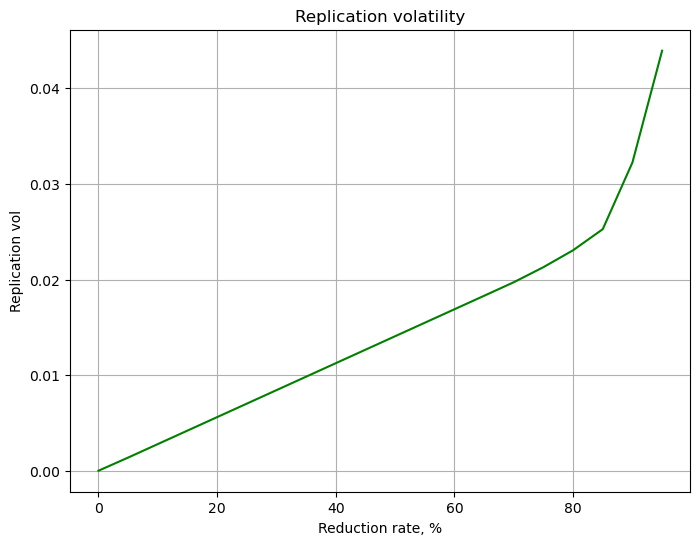

In [130]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(reduction_rates * 100, rep_vols, 'g')
ax.grid()
ax.set_title('Replication volatility')
ax.set_xlabel('Reduction rate, %')
ax.set_ylabel('Replication vol')
plt.show()

### Question 3

In this question, we will reduce the WACI of the benchmark portfolio by rate $\mathcal{R}$ keeping the sectors weights equal for benchmark and optimized portfolio.

(a) Let $s_i$ for $i=1,2$ denote the sector-mapping vector, i.e. $s_{i,j} = 1$ if $j$-th company is in $i$-th sector.

The sector-neutrality constraint reads:
$$
s_i^T w = s_i^T b, \quad i = 1, 2.
$$

(b) We add this constraints to the minimization problem considered in question 2:
$$
\min\left\{ \dfrac{1}{2}w^T\Sigma w - w^T\Sigma b \right\}
$$
$$
\text{s.t.}\ \begin{cases}
\mathbf{1}^Tw = 1, \\
s_1^T w = s_1^T b, \\
s_2^T w = s_2^T b, \\
\mathbf{0} \leq w \leq \mathbf{1}, \\
\mathcal{CI}(w) \leq (1 - \mathcal{R})\mathcal{CI}(b).
\end{cases}
$$

(c) In the QP formulation one should only modify the matrix $A$
$$
\min\left\{ \dfrac{1}{2}w^TP w + w^T q \right\}
$$
$$
\text{s.t.}\ \begin{cases}
Gx \leq h, \\
Ax = b, \\
w^- \leq w \leq w^+,
\end{cases}
$$
where for our problem
$$
P = \Sigma, \quad q = -\Sigma b, \\
G = \mathcal{CI}^T, \quad h = (1 - \mathcal{R})\mathcal{CI}(b), \\
A = \begin{pmatrix}
\mathbf{1}^T \\
s_1^T \\
s_2^T \\
\end{pmatrix}, 
\quad b = \begin{pmatrix}
1 \\
s_1^Tb \\
s_2^Tb \\
\end{pmatrix}\\
w^- = \mathbf{0}, \quad w^+ = \mathbf{1}.
$$

In [127]:
def sector_neutral_optimal_replicating_portfolio(
    reduction_rate: float,
    carbon_intensity: np.ndarray,
    reference_portfolio: np.ndarray,
    covariance_matrix: np.ndarray,
    sector_mappings: np.ndarray
):
    A = np.vstack([
        np.ones_like(reference_portfolio),
        sector_mappings
    ])
    b = np.concatenate([[1], sector_mappings @ reference_portfolio])[:, None]
    np.ones_like(reference_portfolio)
    optimal_portfolio = solve_qp(
        P=covariance_matrix,
        q=-covariance_matrix @ reference_portfolio,
        G=carbon_intensity,
        h=np.array([(1 - reduction_rate) * carbon_intensity @ reference_portfolio]),
        A=A,
        b=b,
        lb=np.zeros_like(reference_portfolio),
        ub=np.ones_like(reference_portfolio), 
        solver="clarabel"
    )
    return optimal_portfolio

(d) $\mathcal{R} = 20\%$. We will also consider carbon intensities of scopes 1 + 2 + 3.

In [145]:
sector_mappings = np.vstack([sector_1, sector_2])

In [146]:
reduction_rate = 0.2

opt_portfolio_20_123 = sector_neutral_optimal_replicating_portfolio(
    reduction_rate=reduction_rate,
    carbon_intensity=carbon_intensity_123,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat,
    sector_mappings=sector_mappings
)
print('Optimized portfolio: ', opt_portfolio_20_123)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_20_123, weights_ref, cov_mat))

Optimized portfolio:  [0.195 0.152 0.179 0.135 0.1   0.091 0.037 0.111]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.00767451889883405


#### Sanity check

In [147]:
print('Weights sum =', np.sum(opt_portfolio_20_123))
print('Portfolio CI =', carbon_intensity_123 @ opt_portfolio_20_123)
print('0.8 * CI(b) =', (1 - reduction_rate) * waci_ref_123)
print('Weight of sector 1 (optimized)=', sector_1 @ opt_portfolio_20_123)
print('Weight of sector 1 (reference)=', sector_1 @ weights_ref)

Weights sum = 0.9999999999999825
Portfolio CI = 29.830476780307695
0.8 * CI(b) = 29.83049011437536
Weight of sector 1 (optimized)= 0.599999999999983
Weight of sector 1 (reference)= 0.6


(d) Same question for $\mathcal{R} = 30\%, 50\%, 70\%$.

In [148]:
reduction_rate = 0.3

opt_portfolio_30_123 = sector_neutral_optimal_replicating_portfolio(
    reduction_rate=reduction_rate,
    carbon_intensity=carbon_intensity_123,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat,
    sector_mappings=sector_mappings
)
print('Optimized portfolio: ', opt_portfolio_30_123)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_30_123, weights_ref, cov_mat))

Optimized portfolio:  [0.192 0.143 0.184 0.137 0.095 0.087 0.026 0.136]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.01151177006035631


In [150]:
reduction_rate = 0.5

opt_portfolio_50_123 = sector_neutral_optimal_replicating_portfolio(
    reduction_rate=0.5,
    carbon_intensity=carbon_intensity_123,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat,
    sector_mappings=sector_mappings
)
print('Optimized portfolio: ', opt_portfolio_50_123)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_50_123, weights_ref, cov_mat))

Optimized portfolio:  [0.187 0.124 0.193 0.142 0.086 0.078 0.004 0.187]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.01918627701732338


In [151]:
reduction_rate = 0.7

opt_portfolio_70_123 = sector_neutral_optimal_replicating_portfolio(
    reduction_rate=0.7,
    carbon_intensity=carbon_intensity_123,
    reference_portfolio=weights_ref,
    covariance_matrix=cov_mat,
    sector_mappings=sector_mappings
)
print('Optimized portfolio: ', opt_portfolio_70_123)
print('Benchmark portfolio: ', list(weights_ref))
print('Replication volatility =', replication_vol(opt_portfolio_70_123, weights_ref, cov_mat))

Optimized portfolio:  [2.051e-01 8.811e-02 1.776e-01 1.558e-01 3.363e-03 6.144e-02 1.089e-07
 3.085e-01]
Benchmark portfolio:  [0.2, 0.17, 0.17, 0.13, 0.11, 0.1, 0.06, 0.06]
Replication volatility = 0.02825432656049339


In [158]:
reduction_rates = 0.01 * np.arange(0, 90, 5)
rep_vols = []
rep_vols_esct_neutr = []

for reduction_rate in reduction_rates:
    opt_portfolio = optimal_replicating_portfolio(
        reduction_rate=reduction_rate,
        carbon_intensity=carbon_intensity_123,
        reference_portfolio=weights_ref,
        covariance_matrix=cov_mat,
    )
    opt_portfolio_sect_neut = sector_neutral_optimal_replicating_portfolio(
        reduction_rate=reduction_rate,
        carbon_intensity=carbon_intensity_123,
        reference_portfolio=weights_ref,
        covariance_matrix=cov_mat,
        sector_mappings=sector_mappings
    )
    rep_vols.append(replication_vol(opt_portfolio, weights_ref, cov_mat))
    rep_vols_esct_neutr.append(replication_vol(opt_portfolio_sect_neut, weights_ref, cov_mat))

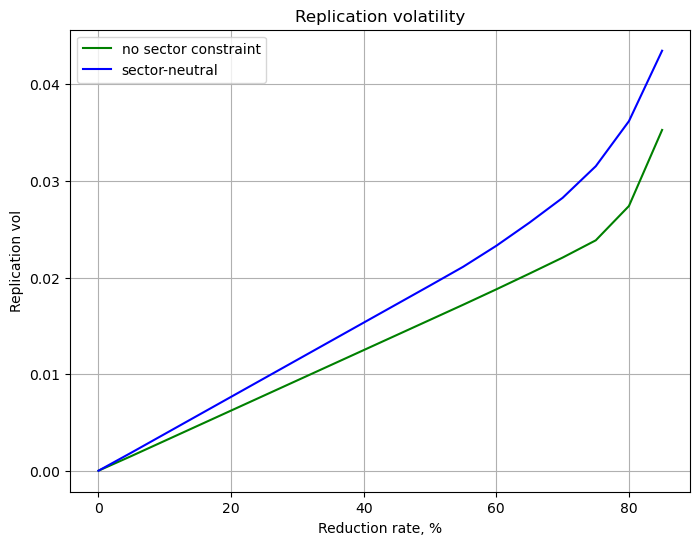

In [161]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(reduction_rates * 100, rep_vols, 'g', label='no sector constraint')
ax.plot(reduction_rates * 100, rep_vols_esct_neutr, 'b', label='sector-neutral')
ax.grid()
ax.legend()
ax.set_title('Replication volatility')
ax.set_xlabel('Reduction rate, %')
ax.set_ylabel('Replication vol')
plt.show()

As expected, replication vol is higher when sector constraint is present.